In [49]:
import pandas as pd
import numpy as np
import httpx
from datetime import datetime
import matplotlib.pyplot as plt

# Функции

## Функция для получения данных

In [101]:
async def fetch_data(url, params):
    async with httpx.AsyncClient() as client:
        try:
            response = await client.get(url, params=params, timeout=10.0)
            response.raise_for_status()
            result = response.json()
            return result

        except httpx.RequestError as e:
            return {"error": f"Request failed: {str(e)}"}
        except httpx.HTTPStatusError as e:
            return {"error": f"HTTP error: {str(e)}"}

## Функция для получения данных по свечам

In [102]:
async def get_bybit_kline(url,  symbol = "BTCUSDT", interval = "1", limit = 25):
    params = {
        "category": "spot",
        "symbol": symbol,
        "interval": interval,
        "limit": limit,
    }
    data = await fetch_data(url, params)

    return data

In [137]:
async def get_binance_kline(url,  symbol = "BTCUSDT", interval = "1m", limit = 25):
    params = {
        "symbol": symbol,
        "interval": interval,
        "timeZone": "+5",
        "limit": limit,
    }
    data = await fetch_data(url, params)

    return data

## Функция для приведения данных о свечах к единному формату

In [112]:
def format_kline_data(data):
    formatted_list = []
    list = data["list"]

    for elem in list:
        formatted_list.append(
            {
                "time": datetime.fromtimestamp(int(elem[0]) / 1000).strftime("%d-%m-%Y %H:%M:%S"),
                "open": float(elem[1]),
                "high": float(elem[2]),
                "low": float(elem[3]),
                "close": float(elem[4]),
                "volume": float(elem[5]),
                "turnover": float(elem[6]),
            }
        )

    return formatted_list

## Функция для приведения данных о свечах к единному формату для Binance

In [116]:
def format_kline_binance_data(data):
    formatted_list = []

    for elem in data:
        formatted_list.append({
            "time": datetime.fromtimestamp(int(elem[0]) / 1000).strftime("%d-%m-%Y %H:%M:%S"),
            "open": float(elem[1]),
            "high": float(elem[2]),
            "low": float(elem[3]),
            "close": float(elem[4]),
            "volume": float(elem[5]),
        })

    
    return formatted_list

## Функция для формирования датафрейма

In [130]:
def make_dataframe(data):
    df = 0
    dataframes = []

    start_time_object = datetime.strptime(data[0]["time"], "%d-%m-%Y %H:%M:%S")
    end_time_object = datetime.strptime(data[len(data) - 1]["time"], "%d-%m-%Y %H:%M:%S")

    start_time_ms = int(start_time_object.timestamp() * 1000)
    end_time_ms = int(end_time_object.timestamp() * 1000)

    for elem in data:
        elem["open"] = float(elem["open"])
        elem["close"] = float(elem["close"])
        elem["high"] = float(elem["high"])
        elem["low"] = float(elem["low"])
        elem["volume"] = float(elem["volume"])
        dataframes.append(pd.DataFrame(elem, index=[0]))

    initial_df = pd.concat(dataframes, ignore_index=True)

    if start_time_ms > end_time_ms:
        df = initial_df.iloc[::-1].reset_index(drop=True)
    else:
        df = initial_df

    return df

## Функция для расчета осцилятора Чайкина

In [106]:
def chaikin_osc(df):
        # 1. Рассчитать Money Flow Multiplier
    df["mf_multiplier"] = ((df["close"] - df["low"]) - (df["high"] - df["close"])) / (df["high"] - df["low"])

    # 2. Рассчитать Money Flow Volume
    df["mf_volume"] = df["mf_multiplier"] * df["volume"]

    # 3. Рассчитать ADL
    df["adl"] = df["mf_volume"].cumsum()

    # 4. Рассчитать EMA для short и long периодов
    short_period = 3
    long_period = 10

    df["ema_short"] = df["adl"].ewm(span=short_period, adjust=False).mean()
    df["ema_long"] = df["adl"].ewm(span=long_period, adjust=False).mean()

    # 5. Рассчитать Chaikin Oscillator
    df["chaikin_osc"] = df["ema_short"] - df["ema_long"]

    return df

## Функция для расчета RSI

In [107]:
def rsi(df, period):
    df["delta"] = df["close"].diff()  # Разница между текущей и предыдущей ценой закрытия

    df["gain"] = df["delta"].where(df["delta"] > 0, 0)  # Приросты (положительные изменения)
    df["loss"] = -df["delta"].where(df["delta"] < 0, 0)  # Потери (отрицательные изменения)

    # Скользящее среднее приростов и потерь
    df["avg_gain"] = df["gain"].rolling(window=period, min_periods=1).mean()
    df["avg_loss"] = df["loss"].rolling(window=period, min_periods=1).mean()

    # Отношение приростов к потерям
    df["rs"] = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100 / (1 + df["rs"]))  # Формула RSI

    return df

# Bybit

## Получаем данные по свечам

In [108]:
url = "https://api.bybit.com/v5/market/kline"

kline_data = await get_bybit_kline(url, symbol="BTCUSDT", interval=1, limit=1000)
klines = format_kline_data(kline_data["result"])

klines_df_0 = make_dataframe(klines)

klines_df_1 = chaikin_osc(klines_df_0)

klines_df_2 = rsi(klines_df_1, period=14)

# Настройка отображения
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', 0)          # Не ограничивать ширину строки
pd.set_option('display.expand_frame_repr', False)


print(klines_df_2[["time", "open", "close", "volume", "chaikin_osc", "RSI"]])

                    time       open      close     volume  chaikin_osc        RSI
0    18-12-2024 23:44:00  104316.45  104181.96  19.337739     0.000000        NaN
1    18-12-2024 23:45:00  104181.96  104137.91  18.335057    -5.769949   0.000000
2    18-12-2024 23:46:00  104137.91  104322.21  26.161893    -1.521466  80.709437
3    18-12-2024 23:47:00  104322.21  104288.28  19.358850    -5.804770  70.268415
4    18-12-2024 23:48:00  104288.28  104252.87  15.157876   -11.852284  61.910041
..                   ...        ...        ...        ...          ...        ...
995  19-12-2024 16:19:00  102308.95  102334.74   8.357965    -8.830120  47.695621
996  19-12-2024 16:20:00  102334.74  102348.44  17.425284    -7.914662  46.869227
997  19-12-2024 16:21:00  102348.44  102391.92  11.034251    -3.623731  52.977311
998  19-12-2024 16:22:00  102391.92  102349.45  10.453965    -3.018050  54.468340
999  19-12-2024 16:23:00  102349.45  102362.01   1.764924    -1.971656  51.607134

[1000 rows x 6 

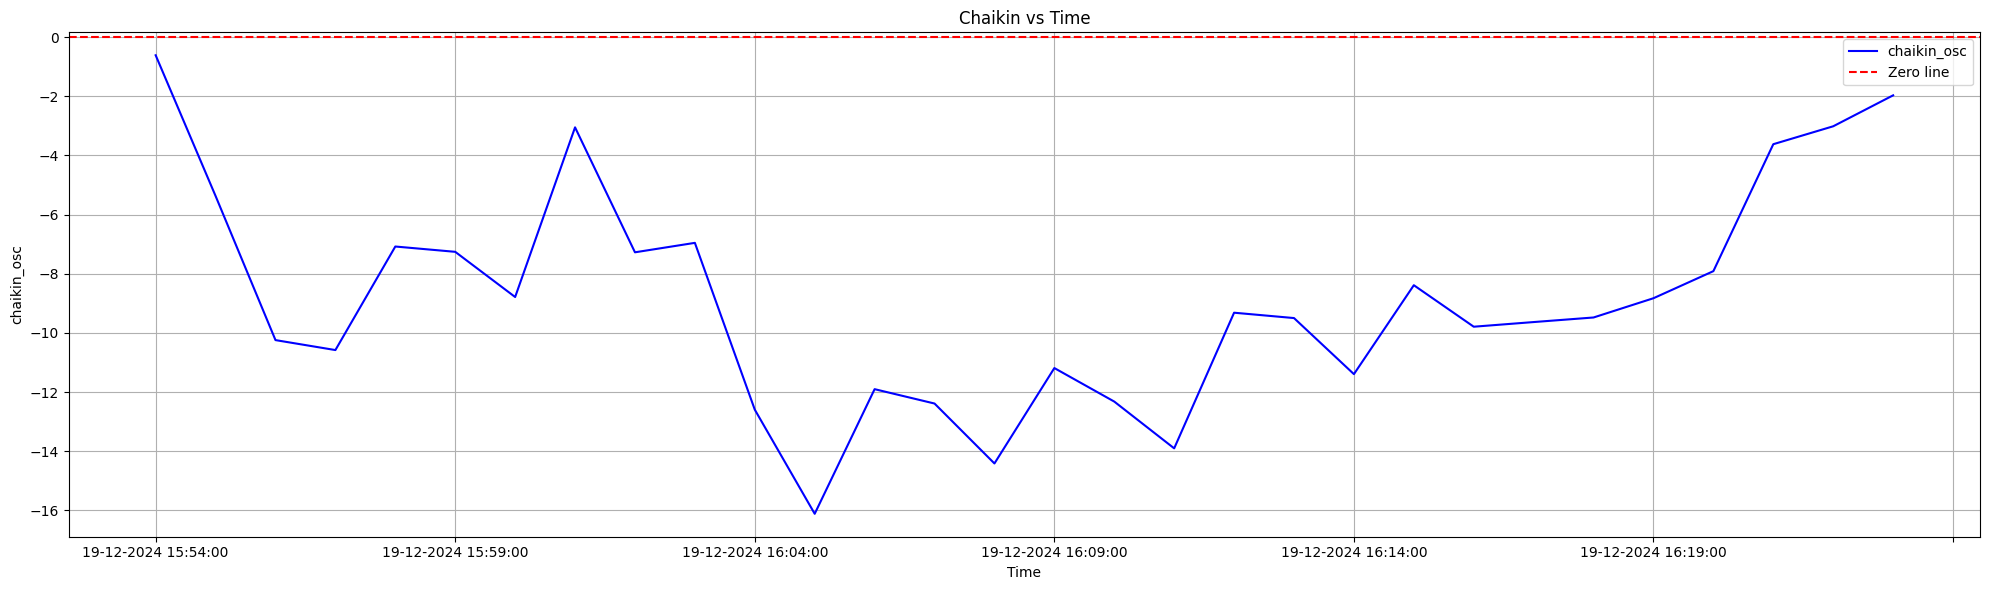

In [109]:
klines_df_2[-30:].plot(
    x='time', 
    y='chaikin_osc', 
    figsize=(20, 6),  # Размер графика
    title='Chaikin vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 0
plt.axhline(0, color='red', linestyle='--', label='Zero line')


plt.legend()
plt.xlabel('Time')
plt.ylabel('chaikin_osc')
plt.tight_layout()
plt.show()

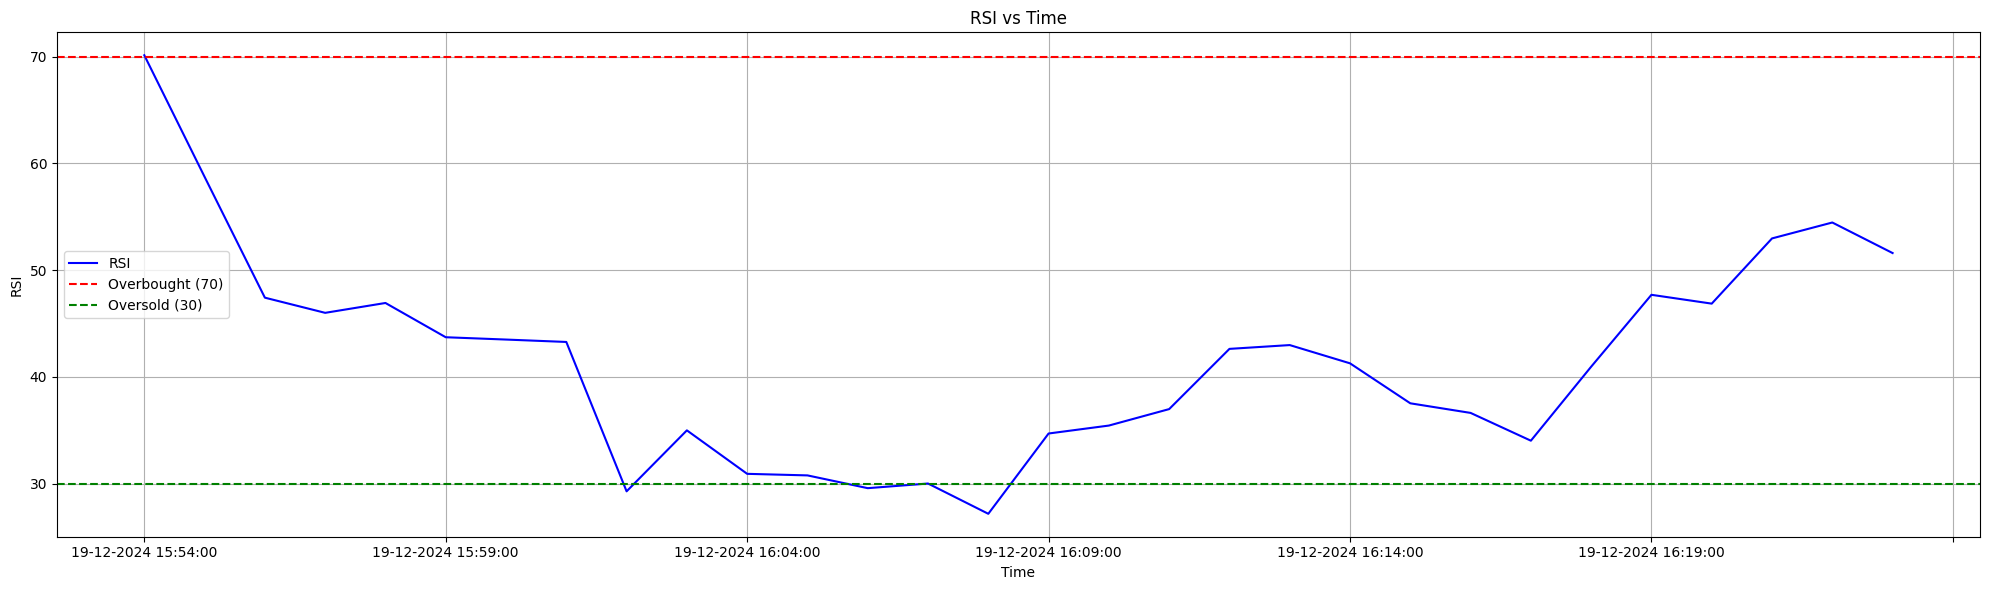

In [110]:
klines_df_2[-30:].plot(
    x='time', 
    y='RSI', 
    figsize=(20, 6),  # Размер графика
    title='RSI vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 70 и 30
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSI')
plt.tight_layout()
plt.show()

# Binance

In [138]:
url = "https://api.binance.com/api/v3/klines"

kline_data = await get_binance_kline(url, symbol="BTCUSDT", interval="1m", limit=1000)
klines = format_kline_binance_data(kline_data)

klines_df_0 = make_dataframe(klines)

klines_df_1 = chaikin_osc(klines_df_0)

klines_df_2 = rsi(klines_df_1, period=14)

# Настройка отображения
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', 0)          # Не ограничивать ширину строки
pd.set_option('display.expand_frame_repr', False)


print(klines_df_2[["time", "open", "close", "volume", "chaikin_osc", "RSI"]])

                    time       open      close     volume  chaikin_osc        RSI
0    19-12-2024 00:46:00  103491.13  103400.01  210.73437     0.000000        NaN
1    19-12-2024 00:47:00  103400.01  103365.55  194.35332   -33.299531   0.000000
2    19-12-2024 00:48:00  103365.55  103153.27  328.87221  -119.440343   0.000000
3    19-12-2024 00:49:00  103153.27  103361.42  140.51148  -104.602136  45.758315
4    19-12-2024 00:50:00  103361.43  103206.14   48.83109  -103.589409  34.113444
..                   ...        ...        ...        ...          ...        ...
995  19-12-2024 17:21:00  102448.85  102454.50   16.92358    11.825389  38.943863
996  19-12-2024 17:22:00  102454.49  102371.18    6.62802    10.115213  35.258899
997  19-12-2024 17:23:00  102371.18  102394.10   11.57636    10.883655  41.028250
998  19-12-2024 17:24:00  102394.10  102357.64    7.20747     9.296879  31.259216
999  19-12-2024 17:25:00  102357.64  102329.49    3.02401     6.840387  32.613841

[1000 rows x 6 

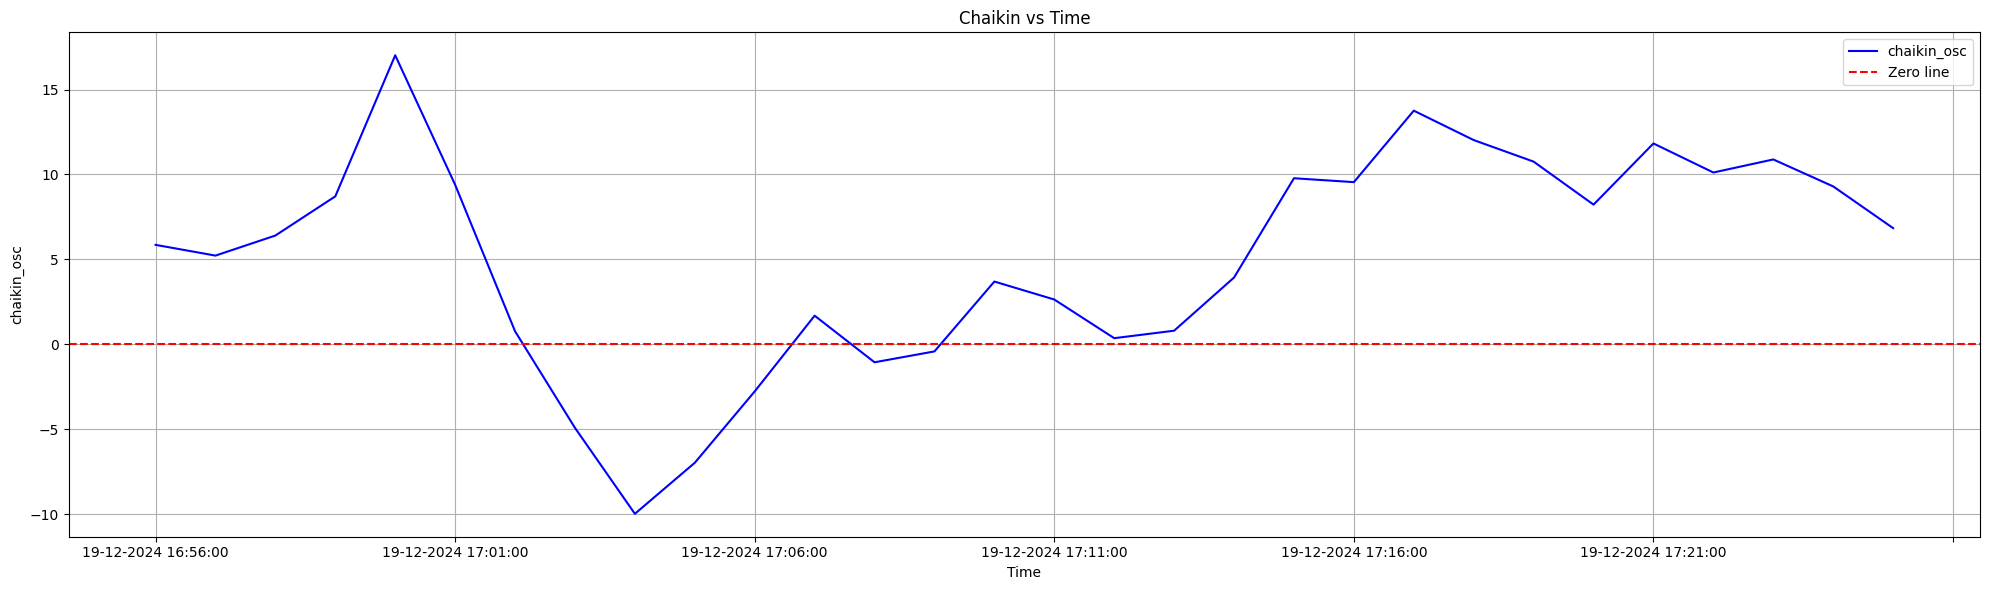

In [139]:
klines_df_2[-30:].plot(
    x='time', 
    y='chaikin_osc', 
    figsize=(20, 6),  # Размер графика
    title='Chaikin vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 0
plt.axhline(0, color='red', linestyle='--', label='Zero line')


plt.legend()
plt.xlabel('Time')
plt.ylabel('chaikin_osc')
plt.tight_layout()
plt.show()

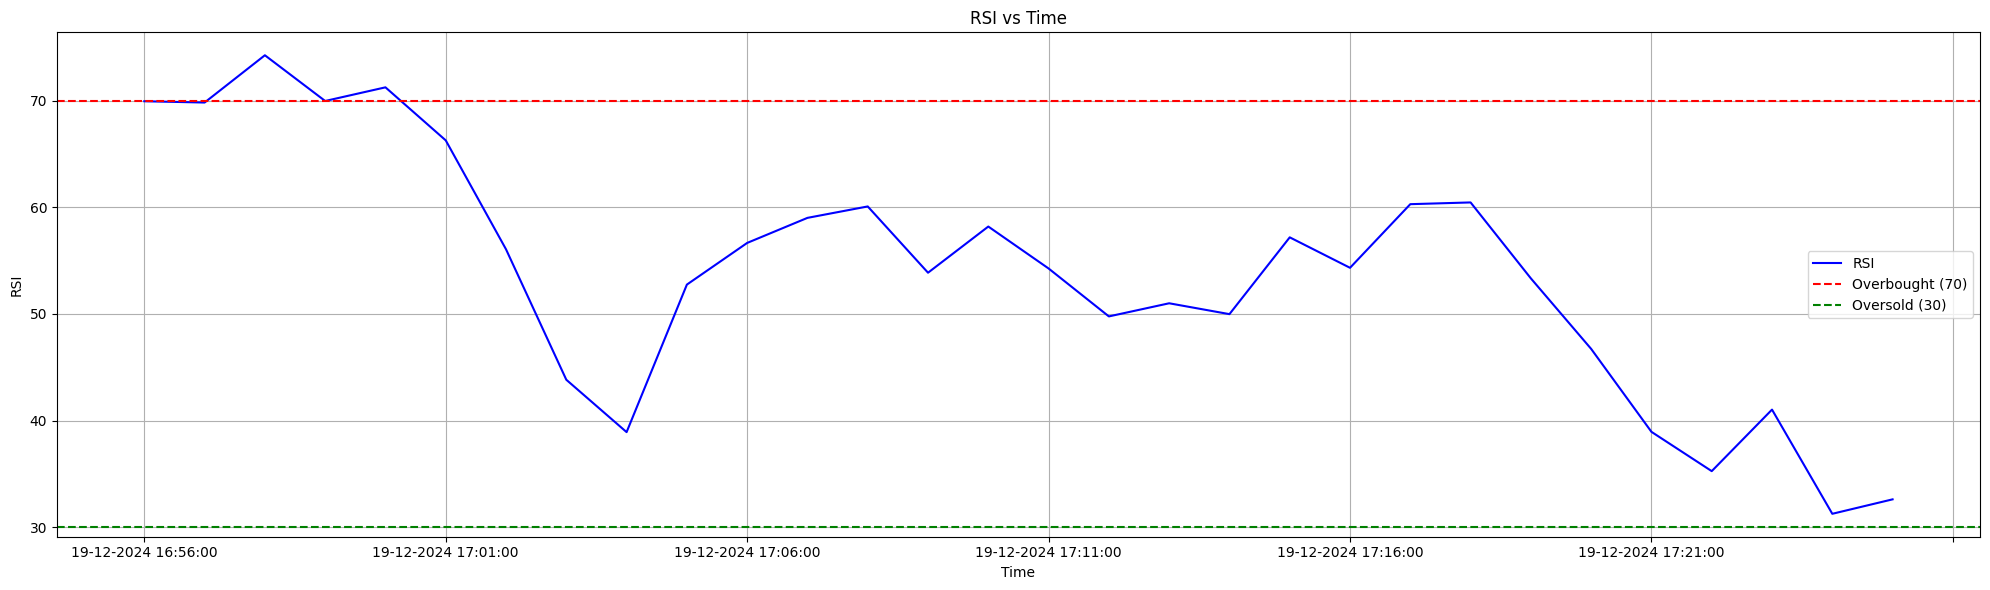

In [140]:
klines_df_2[-30:].plot(
    x='time', 
    y='RSI', 
    figsize=(20, 6),  # Размер графика
    title='RSI vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 70 и 30
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSI')
plt.tight_layout()
plt.show()